In [1]:
import matplotlib.pyplot as plt
from functools import reduce
import pandas as pd
from system import FLSInventoryManagement as flsystem

In [2]:
system = flsystem()

method_quantity = 'som'
method_urgency = 'mom'
inventory_input = 10
days_input = 35
quantity_result, urgency_result = system.get_result(inventory_input, days_input, method_quantity, method_urgency)
aggregated_quantity,aggregated_urgency = system.get_aggregated(inventory_input, days_input)

In [3]:
def plotting_subplot(axes, x, functionList, clr, labels, title, kind, symbol, index, aggregated=None, specific_x_val=None):
    # Determine if `axes` is 1D or 2D
    if axes.ndim == 1:  # 1D array of subplots
        ax = axes[index]
    else:  # 2D array of subplots
        rows, cols = axes.shape
        row = index // cols
        col = index % cols
        ax = axes[row, col]

    # Plot the membership functions
    for ind in range(len(functionList)):
        ax.plot(x, functionList[ind], color=clr[ind], label=labels[ind])
    
    # Plot and shade the aggregated curve
    if aggregated is not None:
        ax.plot(x, aggregated, color='purple', label="Aggregated")
        ax.fill_between(x, aggregated, color='purple', alpha=0.3)
    
    # Add a vertical line for specific x-value
    if specific_x_val is not None:
        ax.plot([specific_x_val, specific_x_val], [0, 1], color='brown', label="Value")

    # Set subplot title, labels, and grid
    ax.set_title(f"{title} ({kind + ' ' + symbol})", fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=8)
    ax.set_xlabel("x-axis")
    ax.set_ylabel("Membership Degree")

"""ArithmeticError
# Example inputs
x = [system.get_variables("Inventory")[0], system.get_variables("Days")[0],
      system.get_variables("Quantity")[0], system.get_variables("Urgency")[0]]
func = [system.get_variables("Inventory")[1], system.get_variables("Days")[1],
         system.get_variables("Quantity")[1], system.get_variables("Urgency")[1]]
clrs = [['r','g','b'],['r','g','b'],['k','r','g','b'], ['k','r','g','b']]
labels = [['Low','Medium','High'],['Low','Medium','High'],['Zero','Low','Medium','High'],['Zero','Low','Medium','High']]
title = ["Inventory","Days Before Expired","Reorder Quantity", "Reorder Urgency"]
kind = ['Input','Input','Output','Output']
symbol = [' Units', ' Days', ' Units', ' %']

# Create subplots
rows = 2  # Number of rows in the grid
cols = 2  # Number of columns in the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
axes = axes.flatten()  # Flatten axes for easier access

# Loop through and plot on subplots
for i in range(len(x)):
    plotting_subplot(axes, x[i], func[i], clrs[i], labels[i], title[i], kind[i], symbol[i], i)

# Remove any extra subplots (if len(x) < rows * cols)
for j in range(len(x), rows * cols):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()
"""
print()

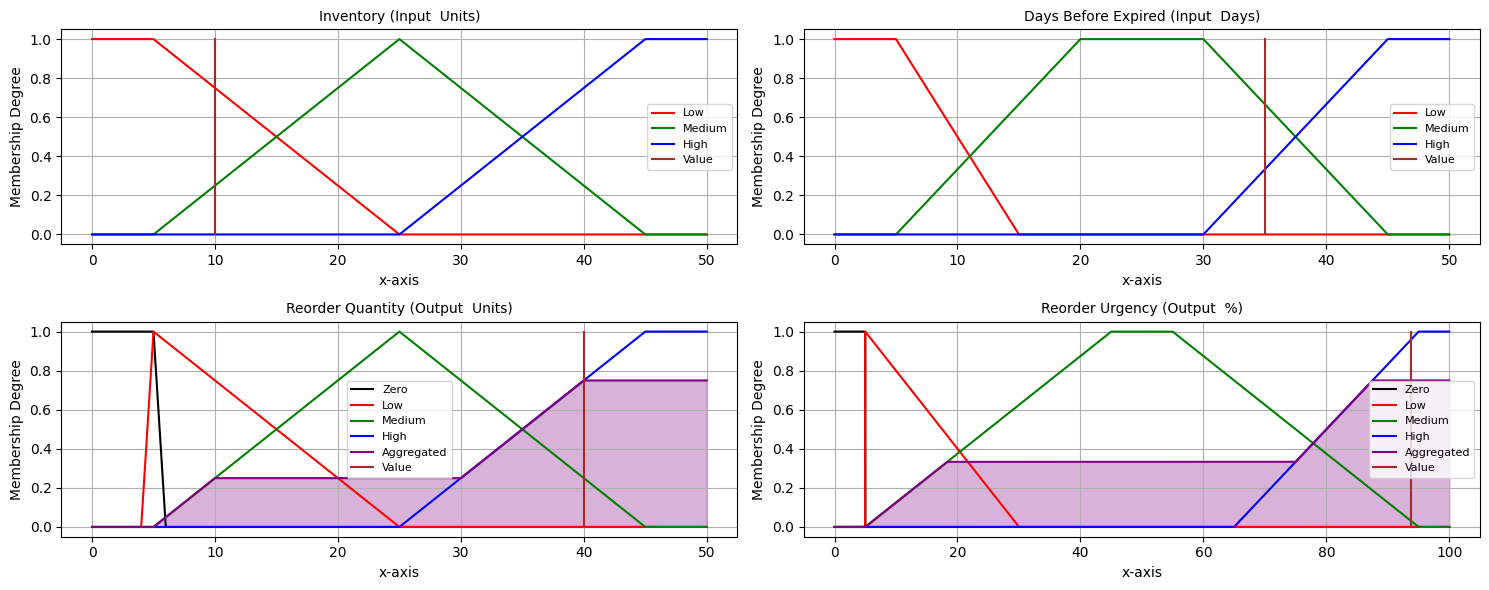

In [4]:

# Example inputs
x = [system.get_variables("Inventory")[0], system.get_variables("Days")[0],
      system.get_variables("Quantity")[0], system.get_variables("Urgency")[0]]
func = [system.get_variables("Inventory")[1], system.get_variables("Days")[1],
         system.get_variables("Quantity")[1], system.get_variables("Urgency")[1]]
clrs = [['r','g','b'],['r','g','b'],['k','r','g','b'], ['k','r','g','b']]
labels = [['Low','Medium','High'],['Low','Medium','High'],['Zero','Low','Medium','High'],['Zero','Low','Medium','High']]
title = ["Inventory","Days Before Expired","Reorder Quantity", "Reorder Urgency"]
kind = ['Input','Input','Output','Output']
symbol = [' Units', ' Days', ' Units', ' %']
aggregated = [None,None,aggregated_quantity,aggregated_urgency]
specific_x_val = [10, 35, quantity_result, urgency_result]

# Create subplots
rows = 2  # Number of rows in the grid
cols = 2  # Number of columns in the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
axes = axes.flatten()  # Flatten axes for easier access

# Loop through and plot on subplots
for i in range(len(x)):
    plotting_subplot(axes, x[i], func[i], clrs[i], labels[i], title[i], kind[i], symbol[i], i, aggregated[i], specific_x_val[i])

# Remove any extra subplots (if len(x) < rows * cols)
for j in range(len(x), rows * cols):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [5]:
dataset = pd.read_csv("inventory.csv")
days_list = [48,41,35,25,15,8,1, -5]

# Create a list of DataFrames for each scenario
res_dataset = []
for ind in range(len(days_list)):
    dataset['days_bf_exp'] = days_list[ind]
    res = dataset.copy()
    res_dataset.append(res)

col = list(dataset.columns)

# Merge all DataFrames in the list
df = res_dataset[0]
for ind in range(1, len(res_dataset)):
    df = df.merge(res_dataset[ind], on=col, how='outer') 

df = df[['item_id','days_bf_exp','quantity']]
df = df.sort_values(['days_bf_exp','item_id'])
df.reset_index(inplace = True)
df = df[df.columns.drop(['index'])]

In [8]:
df['reorder_quantity'] = 0.0
df['reorder_urgency'] = 0.0
method_quantity = 'som'
method_urgency = 'mom'
for i in range(len(df)):
        quantity = df.iloc[i]['quantity']
        days_to_expiry = df.iloc[i]['days_bf_exp']
        reorder_quantity, reorder_urgency = system.get_result(
            quantity, days_to_expiry, method_quantity, method_urgency
        )
        aggregated_quantity,aggregated_urgency = system.get_aggregated(
            quantity, days_to_expiry
        )
        df.at[i, 'reorder_quantity'] = reorder_quantity
        df.at[i, 'reorder_urgency'] = reorder_urgency
        """
        if i % 7 == 0:
            print(i)
        print((quantity, days_to_expiry))
        ArithmeticError
        # Example inputs
        x = [system.get_variables("Inventory")[0], system.get_variables("Days")[0],
            system.get_variables("Quantity")[0], system.get_variables("Urgency")[0]]
        func = [system.get_variables("Inventory")[1], system.get_variables("Days")[1],
                system.get_variables("Quantity")[1], system.get_variables("Urgency")[1]]
        clrs = [['r','g','b'],['r','g','b'],['k','r','g','b'], ['k','r','g','b']]
        labels = [['Low','Medium','High'],['Low','Medium','High'],['Zero','Low','Medium','High'],['Zero','Low','Medium','High']]
        title = ["Inventory","Days Before Expired","Reorder Quantity", "Reorder Urgency"]
        kind = ['Input','Input','Output','Output']
        symbol = [' Units', ' Days', ' Units', ' %']
        aggregated = [None,None,aggregated_quantity,aggregated_urgency]
        specific_x_val = [quantity, days_to_expiry, reorder_quantity, reorder_urgency]

        # Create subplots
        rows = 2  # Number of rows in the grid
        cols = 2  # Number of columns in the grid
        fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
        axes = axes.flatten()  # Flatten axes for easier access

        # Loop through and plot on subplots
        for i in range(len(x)):
            plotting_subplot(axes, x[i], func[i], clrs[i], labels[i], title[i], kind[i], symbol[i], i, aggregated[i], specific_x_val[i])

        # Remove any extra subplots (if len(x) < rows * cols)
        for j in range(len(x), rows * cols):
            fig.delaxes(axes[j])

        # Adjust layout
        plt.tight_layout()
        plt.show()
        """
new_df = df.copy()
# new_df['difference'] = new_df['reorder_quantity'] - new_df['quantity']
new_df

,item_id,days_bf_exp,quantity,reorder_quantity,reorder_urgency
0,1,-5,4,45.0,97.50
1,2,-5,10,40.0,93.75
2,3,-5,17,17.0,50.00
3,4,-5,25,25.0,50.00
4,5,-5,32,18.0,50.00
5,6,-5,41,0.0,2.50
6,7,-5,49,0.0,2.50
7,1,1,4,45.0,97.50
8,2,1,10,40.0,93.75
9,3,1,17,17.0,50.00
